# How can restaurant hook potential Yelp reviews with high-stars
- Data Source: https://www.yelp.com/dataset/documentation/main

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.lda import LDA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import IsolationForest, RandomForestRegressor

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module wi

In [2]:
LIMIT = 10000

In [3]:
yelp = pd.read_csv("Data/yelp.csv", nrows=LIMIT)

In [4]:
yelp.head(2)

,business_id,review_cool,review_funny,review_id,review_stars,review,review_useful,user_id,review_len,review_afinn_score,...,checkin_count,var_checkin,b_tip_compliment_count,b_tip_len,b_tip_afinn_score,b_tip_polarity,b_tip_compound,b_tip_positive,b_tip_negative,b_tip_neutral
0,ujmEBvifdJM6h6RLv4wQIg,0,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6.0,hG7b0MtEbXx5QzbzE6C_VA,204.0,-2.0,...,1599.0,10.045591,0.125,87.337500,0.420903,0.164938,0.158531,0.165675,0.067,0.767312
1,xpEq8x5caXFm2lmjQ51rVQ,0,0,D4_FpPSPRNtAj1964vXFPQ,2.0,Unable to get their over the air signal. So wh...,2.0,hG7b0MtEbXx5QzbzE6C_VA,327.0,1.0,...,105.0,1783.739320,0.000,55.833333,1.333333,0.272751,0.369767,0.233500,0.000,0.766500


## 1. Feature Engineering

### 1.1. Extract all numeric features and nan values

In [5]:
numerics = ['review_stars', 'review_funny', 'review_cool', 'review_useful', 'review_len', 'review_afinn_score', 
            'review_polarity', 'review_compound', 'review_positive', 'review_negative', 'review_neutral', 
            'tip_compliment_count', 'tip_len', 'tip_afinn_score', 'tip_polarity', 'tip_compound', 'tip_positive', 
            'tip_negative', 'tip_neutral', 'user_review_count', 'user_useful', 'user_funny', 'user_cool', 'fans',
            'user_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 
            'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 
            'compliment_writer', 'compliment_photos', 'num_elite', 'num_friends', 'days_with_yelp', 
            'count_categories', 'latitude', 'longitude', 'business_review_count', 'business_stars', 'Monday', 
            'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'drink', 'food', 'inside', 'menu', 
            'outside', 'avg_checkin', 'checkin_count', 'var_checkin', 'b_tip_compliment_count', 'b_tip_len', 
            'b_tip_afinn_score', 'b_tip_polarity', 'b_tip_compound', 'b_tip_positive', 'b_tip_negative', 
            'b_tip_neutral']

In [6]:
yelp = yelp[yelp.review_cool.map(type) != str].dropna(how="any")

In [7]:
yelp.review_cool = yelp.review_cool.astype("float")

### 1.2. Normalization

#### 1.2.1. Check original variation first

In [8]:
yelp[numerics].iloc[:, 0].std()

1.2107273954456503

In [9]:
sorted(yelp[numerics].iloc[:, 1:].std())[:5]

[0.03086581126302378,
 0.05043396573986998,
 0.0517423739410057,
 0.05284825613137809,
 0.05379303313786198]

In [10]:
normalized = (yelp[numerics].iloc[:, 1:] - yelp[numerics].iloc[:, 1:].mean()) / yelp[numerics].iloc[:, 1:].std()
normalized.head()

,review_funny,review_cool,review_useful,review_len,review_afinn_score,review_polarity,review_compound,review_positive,review_negative,review_neutral,...,checkin_count,var_checkin,b_tip_compliment_count,b_tip_len,b_tip_afinn_score,b_tip_polarity,b_tip_compound,b_tip_positive,b_tip_negative,b_tip_neutral
0,-0.053568,-0.562072,0.875663,-0.930845,-3.210461,-2.689406,-2.958642,-1.783519,2.191911,0.632897,...,0.131515,-0.190055,2.105772,0.794980,-0.991998,-0.526315,-0.780655,-0.683322,0.499094,0.598865
1,-0.485568,-0.562072,-0.184141,-0.746952,-0.375503,-1.126560,0.070360,-0.307846,0.129403,0.252312,...,-0.221203,-0.122873,-0.310043,-0.224523,0.146960,0.057232,0.225586,-0.140938,-0.829376,0.594412
2,-0.485568,-0.562072,0.080810,0.686817,-2.625470,-1.253987,-3.372441,-0.912462,2.570353,-0.508859,...,0.131515,-0.190055,2.105772,0.794980,-0.991998,-0.526315,-0.780655,-0.683322,0.499094,0.598865
3,-0.485568,-0.562072,-0.714043,-0.718546,-1.050493,0.226085,-2.415031,-0.512801,2.324366,-0.780706,...,-0.160764,-0.185569,0.530240,-0.168478,-1.227944,-1.241576,-1.357883,-1.150796,0.562026,0.901935
4,-0.485568,-0.562072,-0.714043,-1.028025,0.569483,0.145330,0.267075,0.901386,0.034792,-0.976435,...,-0.009194,-0.189534,1.251696,0.693186,-0.498179,-0.451995,-0.527751,-0.406166,0.520123,0.403053


### 1.3. Check if we need binarization: a small sample is enough to check

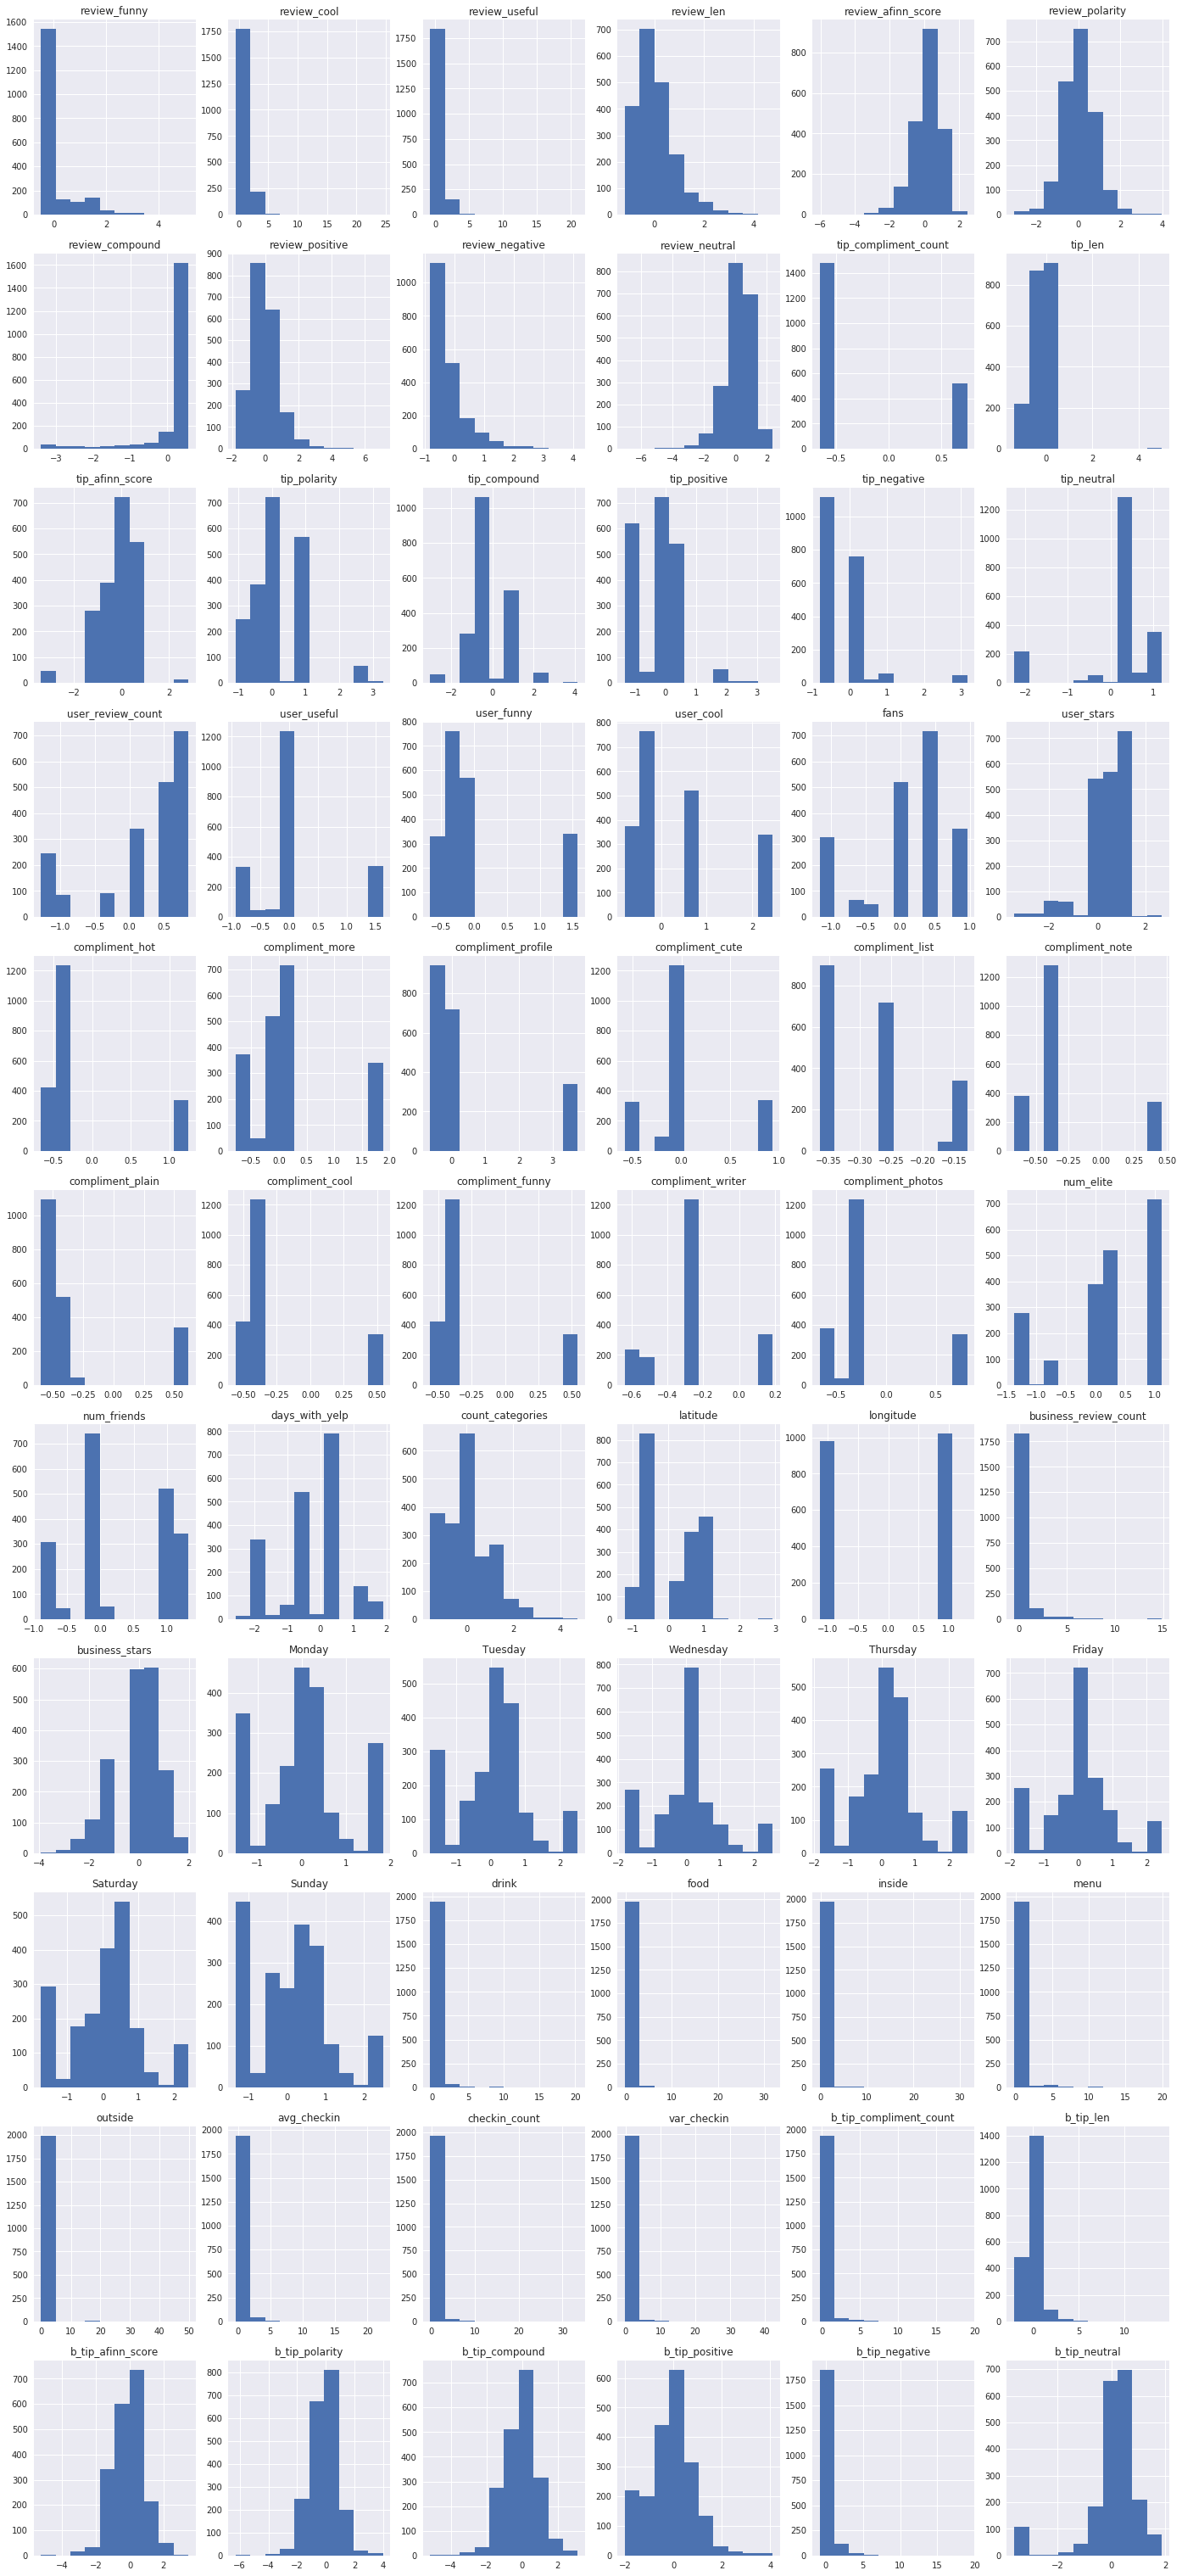

In [11]:
f = plt.figure(figsize=(24, 55))
for i, column in enumerate(numerics[1:]):
    ax = f.add_subplot(11, 6, i + 1)
    ax.hist(normalized.iloc[:2000, :][column])
    ax.set_title(column)

### 1.4. If we need some polynominal features

In [12]:
PolynomialFeatures(degree=2).fit_transform(normalized).shape

(10000, 2278)

### 1.5. Feature Selection: actually, using all features brings a best result

#### 1.5.1. Select by correlations

In [13]:
def SelectKBest(X, Y, K):
    if K >= len(X.columns):
        return X
    else:
        res = []
        for column in X.columns:
            res.append((column, Y.corr(X[column])))
        return X[[i[0] for i in sorted(res, key=lambda x: -x[1])[:K]]]

K_best_normalized_1 = SelectKBest(normalized, yelp["review_stars"], K=40)
K_best_normalized_1.head()

,review_afinn_score,review_compound,review_polarity,review_positive,business_stars,user_stars,tip_compound,b_tip_afinn_score,b_tip_compound,b_tip_polarity,...,fans,compliment_cute,compliment_photos,user_review_count,user_useful,b_tip_len,compliment_profile,var_checkin,review_useful,compliment_hot
0,-3.210461,-2.958642,-2.689406,-1.783519,-1.717238,-3.454316,-1.047955,-0.991998,-0.780655,-0.526315,...,-1.15891,-0.578925,-0.66296,-1.261533,-0.920428,0.794980,-0.638739,-0.190055,0.875663,-0.661826
1,-0.375503,0.070360,-1.126560,-0.307846,-0.977145,-3.454316,-1.047955,0.146960,0.225586,0.057232,...,-1.15891,-0.578925,-0.66296,-1.261533,-0.920428,-0.224523,-0.638739,-0.122873,-0.184141,-0.661826
2,-2.625470,-3.372441,-1.253987,-0.912462,-1.717238,-3.454316,-1.047955,-0.991998,-0.780655,-0.526315,...,-1.15891,-0.578925,-0.66296,-1.261533,-0.920428,0.794980,-0.638739,-0.190055,0.080810,-0.661826
3,-1.050493,-2.415031,0.226085,-0.512801,-2.457332,-3.454316,-1.047955,-1.227944,-1.357883,-1.241576,...,-1.15891,-0.578925,-0.66296,-1.261533,-0.920428,-0.168478,-0.638739,-0.185569,-0.714043,-0.661826
4,0.569483,0.267075,0.145330,0.901386,-0.977145,-3.454316,-1.047955,-0.498179,-0.527751,-0.451995,...,-1.15891,-0.578925,-0.66296,-1.261533,-0.920428,0.693186,-0.638739,-0.189534,-0.714043,-0.661826


#### 1.5.2. Select by Wrapper Method: too slow to run on big dataset

In [14]:
K_best_normalized_2 = RFE(estimator=XGBRegressor()).fit_transform(normalized, yelp["review_stars"])
K_best_normalized_2.shape

(10000, 33)

In [15]:
K_best_normalized_2_indexes = []
for value in K_best_normalized_2[0, :].tolist():
    K_best_normalized_2_indexes += normalized.iloc[0, :][normalized.iloc[0, :] == value].index.tolist()
K_best_normalized_2 = pd.DataFrame(K_best_normalized_2).rename(columns={i: c for i, 
                                                                        c in enumerate(K_best_normalized_2_indexes)})
K_best_normalized_2.head()

,review_funny,review_cool,review_useful,review_len,review_afinn_score,review_polarity,review_compound,review_positive,review_negative,tip_len,...,compliment_cool,compliment_funny,compliment_photos,num_friends,latitude,longitude,business_stars,Sunday,food,var_checkin
0,-0.053568,-0.562072,0.875663,-0.930845,-3.210461,-2.689406,-2.958642,-1.783519,2.191911,-1.369224,...,-0.557998,-0.66296,-0.891594,-0.524124,-1.124840,-1.717238,2.490140,-0.258973,-0.190055,2.105772
1,-0.485568,-0.562072,-0.184141,-0.746952,-0.375503,-1.126560,0.070360,-0.307846,0.129403,-1.369224,...,-0.557998,-0.66296,-0.891594,-0.543788,-1.119768,-0.977145,-1.335352,-0.258973,-0.122873,-0.310043
2,-0.485568,-0.562072,0.080810,0.686817,-2.625470,-1.253987,-3.372441,-0.912462,2.570353,-1.369224,...,-0.557998,-0.66296,-0.891594,-0.524124,-1.124840,-1.717238,2.490140,-0.258973,-0.190055,2.105772
3,-0.485568,-0.562072,-0.714043,-0.718546,-1.050493,0.226085,-2.415031,-0.512801,2.324366,-1.369224,...,-0.557998,-0.66296,-0.891594,-0.527482,-1.121514,-2.457332,1.533767,-0.258973,-0.185569,0.530240
4,-0.485568,-0.562072,-0.714043,-1.028025,0.569483,0.145330,0.267075,0.901386,0.034792,-1.369224,...,-0.557998,-0.66296,-0.891594,-0.547392,-1.121729,-0.977145,-1.335352,-0.095480,-0.189534,1.251696


In [16]:
K_best_normalized_3 = RFE(estimator=LGBMRegressor()).fit_transform(normalized, yelp["review_stars"])
K_best_normalized_3.shape

(10000, 33)

In [17]:
K_best_normalized_3_indexes = []
for value in K_best_normalized_3[0, :].tolist():
    K_best_normalized_3_indexes += normalized.iloc[0, :][normalized.iloc[0, :] == value].index.tolist()
K_best_normalized_3 = pd.DataFrame(K_best_normalized_3).rename(columns={i: c for i, 
                                                                        c in enumerate(K_best_normalized_3_indexes)})
K_best_normalized_3.head()

,review_funny,review_cool,review_useful,review_len,review_afinn_score,review_polarity,review_compound,review_positive,review_negative,review_neutral,...,avg_checkin,checkin_count,var_checkin,b_tip_len,b_tip_afinn_score,b_tip_polarity,b_tip_compound,b_tip_positive,b_tip_negative,b_tip_neutral
0,-0.053568,-0.562072,0.875663,-0.930845,-3.210461,-2.689406,-2.958642,-1.783519,2.191911,0.632897,...,-0.337372,0.131515,-0.190055,0.794980,-0.991998,-0.526315,-0.780655,-0.683322,0.499094,0.598865
1,-0.485568,-0.562072,-0.184141,-0.746952,-0.375503,-1.126560,0.070360,-0.307846,0.129403,0.252312,...,-0.044437,-0.221203,-0.122873,-0.224523,0.146960,0.057232,0.225586,-0.140938,-0.829376,0.594412
2,-0.485568,-0.562072,0.080810,0.686817,-2.625470,-1.253987,-3.372441,-0.912462,2.570353,-0.508859,...,-0.337372,0.131515,-0.190055,0.794980,-0.991998,-0.526315,-0.780655,-0.683322,0.499094,0.598865
3,-0.485568,-0.562072,-0.714043,-0.718546,-1.050493,0.226085,-2.415031,-0.512801,2.324366,-0.780706,...,-0.269228,-0.160764,-0.185569,-0.168478,-1.227944,-1.241576,-1.357883,-1.150796,0.562026,0.901935
4,-0.485568,-0.562072,-0.714043,-1.028025,0.569483,0.145330,0.267075,0.901386,0.034792,-0.976435,...,-0.330050,-0.009194,-0.189534,0.693186,-0.498179,-0.451995,-0.527751,-0.406166,0.520123,0.403053


#### 1.5.3. Select by Embedded Method: slow on big dataset

In [18]:
K_best_normalized_4 = SelectFromModel(XGBRegressor(), 
                                      threshold='1.25*median').fit_transform(normalized, yelp["review_stars"])
K_best_normalized_4.shape

(10000, 22)

In [19]:
K_best_normalized_4_indexes = []
for value in K_best_normalized_4[0, :].tolist():
    K_best_normalized_4_indexes += normalized.iloc[0, :][normalized.iloc[0, :] == value].index.tolist()
K_best_normalized_4 = pd.DataFrame(K_best_normalized_4).rename(columns={i: c for i, 
                                                                        c in enumerate(K_best_normalized_4_indexes)})
K_best_normalized_4.head()

,review_funny,review_cool,review_afinn_score,review_polarity,review_compound,review_positive,review_negative,tip_polarity,tip_negative,tip_neutral,...,user_stars,compliment_hot,compliment_more,compliment_list,num_friends,latitude,longitude,business_stars,Thursday,food
0,-0.053568,-0.562072,-3.210461,-2.689406,-2.958642,-1.783519,2.191911,-1.089277,-0.808741,-2.255218,...,-3.454316,-0.661826,-0.784363,-0.364889,-0.891594,-0.524124,-1.124840,-1.717238,2.535421,-0.258973
1,-0.485568,-0.562072,-0.375503,-1.126560,0.070360,-0.307846,0.129403,-1.089277,-0.808741,-2.255218,...,-3.454316,-0.661826,-0.784363,-0.364889,-0.891594,-0.543788,-1.119768,-0.977145,-0.195948,-0.258973
2,-0.485568,-0.562072,-2.625470,-1.253987,-3.372441,-0.912462,2.570353,-1.089277,-0.808741,-2.255218,...,-3.454316,-0.661826,-0.784363,-0.364889,-0.891594,-0.524124,-1.124840,-1.717238,2.535421,-0.258973
3,-0.485568,-0.562072,-1.050493,0.226085,-2.415031,-0.512801,2.324366,-1.089277,-0.808741,-2.255218,...,-3.454316,-0.661826,-0.784363,-0.364889,-0.891594,-0.527482,-1.121514,-2.457332,1.442873,-0.258973
4,-0.485568,-0.562072,0.569483,0.145330,0.267075,0.901386,0.034792,-1.089277,-0.808741,-2.255218,...,-3.454316,-0.661826,-0.784363,-0.364889,-0.891594,-0.547392,-1.121729,-0.977145,0.896599,-0.095480


In [20]:
K_best_normalized_5 = SelectFromModel(LGBMRegressor(), 
                                      threshold='1.25*median').fit_transform(normalized, yelp["review_stars"])
K_best_normalized_5.shape

(10000, 31)

In [21]:
K_best_normalized_5_indexes = []
for value in K_best_normalized_5[0, :].tolist():
    K_best_normalized_5_indexes += normalized.iloc[0, :][normalized.iloc[0, :] == value].index.tolist()
K_best_normalized_5 = pd.DataFrame(K_best_normalized_5).rename(columns={i: c for i, 
                                                                        c in enumerate(K_best_normalized_5_indexes)})
K_best_normalized_5.head()

,review_funny,review_cool,review_useful,review_len,review_afinn_score,review_polarity,review_compound,review_positive,review_negative,review_neutral,...,checkin_count,var_checkin,b_tip_compliment_count,b_tip_len,b_tip_afinn_score,b_tip_polarity,b_tip_compound,b_tip_positive,b_tip_negative,b_tip_neutral
0,-0.053568,-0.562072,0.875663,-0.930845,-3.210461,-2.689406,-2.958642,-1.783519,2.191911,0.632897,...,0.131515,-0.190055,2.105772,0.794980,-0.991998,-0.526315,-0.780655,-0.683322,0.499094,0.598865
1,-0.485568,-0.562072,-0.184141,-0.746952,-0.375503,-1.126560,0.070360,-0.307846,0.129403,0.252312,...,-0.221203,-0.122873,-0.310043,-0.224523,0.146960,0.057232,0.225586,-0.140938,-0.829376,0.594412
2,-0.485568,-0.562072,0.080810,0.686817,-2.625470,-1.253987,-3.372441,-0.912462,2.570353,-0.508859,...,0.131515,-0.190055,2.105772,0.794980,-0.991998,-0.526315,-0.780655,-0.683322,0.499094,0.598865
3,-0.485568,-0.562072,-0.714043,-0.718546,-1.050493,0.226085,-2.415031,-0.512801,2.324366,-0.780706,...,-0.160764,-0.185569,0.530240,-0.168478,-1.227944,-1.241576,-1.357883,-1.150796,0.562026,0.901935
4,-0.485568,-0.562072,-0.714043,-1.028025,0.569483,0.145330,0.267075,0.901386,0.034792,-0.976435,...,-0.009194,-0.189534,1.251696,0.693186,-0.498179,-0.451995,-0.527751,-0.406166,0.520123,0.403053


#### 1.5.4. PCA

In [22]:
K_best_normalized_6 = PCA(n_components='mle', svd_solver='full').fit_transform(normalized)
K_best_normalized_6.shape

(10000, 65)

## 2. Modelling

### 2.1. Anomaly Detection: check extreme outliers

In [23]:
# Isolation Forest works too slow on big dataset

IF = IsolationForest()
IF.fit(normalized)
pd.Series(IF.predict(normalized)).value_counts()

 1    9000
-1    1000
dtype: int64

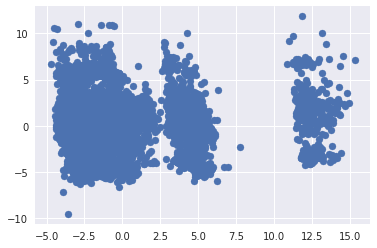

In [24]:
var2 = PCA(n_components=2).fit_transform(normalized)
plt.scatter(var2[:, 0], var2[:, 1])

### 2.2. Metrics

In [25]:
def Accuracies(y_true, y_pred):
    accuracy1 = sum(y_pred == y_true) / len(y_true)
    accuracy2 = sum(y_pred <= y_true) / len(y_true)
    return accuracy1, accuracy2

### 2.3. SVR: too slow to run on big dataset

In [26]:
X = [normalized, K_best_normalized_1, K_best_normalized_2, K_best_normalized_3, K_best_normalized_4, 
     K_best_normalized_5, K_best_normalized_6]
res = {"Precise Accuracy": [], "Benefit Accuracy": [], 5.0: [], 4.0: [], 3.0: [], 2.0: [], 1.0: [], 'Recall': []}

for x in X:
    train_x, test_x, train_y, test_y = train_test_split(x, yelp["review_stars"], train_size=0.7, random_state=999)
    rlf = SVR()
    rlf.fit(train_x, train_y)
    accuracies = Accuracies(test_y, rlf.predict(test_x).round(0))
    counts = dict(pd.Series(rlf.predict(test_x).round(0)).value_counts())
    res["Precise Accuracy"].append(accuracies[0])
    res["Benefit Accuracy"].append(accuracies[1])
    res[1.0].append(counts[1.0])
    res[2.0].append(counts[2.0])
    res[3.0].append(counts[3.0])
    res[4.0].append(counts[4.0])
    res[5.0].append(counts[5.0])
    res["Recall"].append(np.sum(counts[1.0] + counts[2.0] + counts[3.0] + counts[4.0] + counts[5.0]) / len(test_y))
pd.DataFrame(res)

,Benefit Accuracy,1.0,2.0,3.0,4.0,5.0,Precise Accuracy,Recall
0,0.729333,109,260,702,1445,481,0.490333,0.999000
1,0.722333,112,267,685,1436,499,0.485333,0.999667
2,0.737667,129,258,672,1425,513,0.511667,0.999000
3,0.728667,109,265,713,1405,506,0.492000,0.999333
4,0.737000,141,280,646,1403,529,0.506333,0.999667
5,0.723333,103,278,696,1419,499,0.485667,0.998333
6,0.730000,109,259,705,1441,483,0.491333,0.999000


### 2.5. Random Forest

In [27]:
X = [normalized, K_best_normalized_1, K_best_normalized_2, K_best_normalized_3, K_best_normalized_4, 
     K_best_normalized_5, K_best_normalized_6]
res = {"Precise Accuracy": [], "Benefit Accuracy": [], 5.0: [], 4.0: [], 3.0: [], 2.0: [], 1.0: [], 'Recall': []}

for x in X:
    train_x, test_x, train_y, test_y = train_test_split(x, yelp["review_stars"], train_size=0.7, random_state=999)
    rlf = RandomForestRegressor()
    rlf.fit(train_x, train_y)
    accuracies = Accuracies(test_y, rlf.predict(test_x).round(0))
    counts = dict(pd.Series(rlf.predict(test_x).round(0)).value_counts())
    res["Precise Accuracy"].append(accuracies[0])
    res["Benefit Accuracy"].append(accuracies[1])
    res[1.0].append(counts[1.0])
    res[2.0].append(counts[2.0])
    res[3.0].append(counts[3.0])
    res[4.0].append(counts[4.0])
    res[5.0].append(counts[5.0])
    res["Recall"].append(np.sum(counts[1.0] + counts[2.0] + counts[3.0] + counts[4.0] + counts[5.0]) / len(test_y))
pd.DataFrame(res)

,Benefit Accuracy,1.0,2.0,3.0,4.0,5.0,Precise Accuracy,Recall
0,0.741333,109,308,648,1570,365,0.474667,1.0
1,0.739000,114,319,625,1568,374,0.468333,1.0
2,0.734667,105,332,614,1568,381,0.464000,1.0
3,0.735333,103,316,660,1547,374,0.461000,1.0
4,0.737333,110,314,648,1515,413,0.471000,1.0
5,0.742000,104,342,610,1590,354,0.470000,1.0
6,0.728333,93,302,637,1668,300,0.448667,1.0


### 2.6. XGboost: slow on big dataset

In [28]:
X = [normalized, K_best_normalized_1, K_best_normalized_2, K_best_normalized_3, K_best_normalized_4, 
     K_best_normalized_5, K_best_normalized_6]
res = {"Precise Accuracy": [], "Benefit Accuracy": [], 5.0: [], 4.0: [], 3.0: [], 2.0: [], 1.0: [], 'Recall': []}

for x in X:
    train_x, test_x, train_y, test_y = train_test_split(x, yelp["review_stars"], train_size=0.7, random_state=999)
    rlf = XGBRegressor()
    rlf.fit(train_x, train_y)
    accuracies = Accuracies(test_y, rlf.predict(test_x).round(0))
    counts = dict(pd.Series(rlf.predict(test_x).round(0)).value_counts())
    res["Precise Accuracy"].append(accuracies[0])
    res["Benefit Accuracy"].append(accuracies[1])
    res[1.0].append(counts[1.0])
    res[2.0].append(counts[2.0])
    res[3.0].append(counts[3.0])
    res[4.0].append(counts[4.0])
    res[5.0].append(counts[5.0])
    res["Recall"].append(np.sum(counts[1.0] + counts[2.0] + counts[3.0] + counts[4.0] + counts[5.0]) / len(test_y))
pd.DataFrame(res)

,Benefit Accuracy,1.0,2.0,3.0,4.0,5.0,Precise Accuracy,Recall
0,0.738333,103,282,696,1554,365,0.475333,1.000000
1,0.742333,100,284,721,1533,360,0.473333,0.999333
2,0.740333,103,281,708,1526,381,0.480667,0.999667
3,0.740000,107,279,690,1542,382,0.484000,1.000000
4,0.741000,111,276,699,1519,395,0.486667,1.000000
5,0.744000,105,279,695,1562,358,0.481667,0.999667
6,0.732000,79,275,679,1701,266,0.457667,1.000000


### 2.7. LGBM

In [29]:
X = [normalized, K_best_normalized_1, K_best_normalized_2, K_best_normalized_3, K_best_normalized_4, 
     K_best_normalized_5, K_best_normalized_6]
res = {"Precise Accuracy": [], "Benefit Accuracy": [], 5.0: [], 4.0: [], 3.0: [], 2.0: [], 1.0: [], 'Recall': []}

for x in X:
    train_x, test_x, train_y, test_y = train_test_split(x, yelp["review_stars"], train_size=0.7, random_state=999)
    rlf = LGBMRegressor()
    rlf.fit(train_x, train_y)
    accuracies = Accuracies(test_y, rlf.predict(test_x).round(0))
    counts = dict(pd.Series(rlf.predict(test_x).round(0)).value_counts())
    res["Precise Accuracy"].append(accuracies[0])
    res["Benefit Accuracy"].append(accuracies[1])
    res[1.0].append(counts[1.0])
    res[2.0].append(counts[2.0])
    res[3.0].append(counts[3.0])
    res[4.0].append(counts[4.0])
    res[5.0].append(counts[5.0])
    res["Recall"].append(np.sum(counts[1.0] + counts[2.0] + counts[3.0] + counts[4.0] + counts[5.0]) / len(test_y))
pd.DataFrame(res)

,Benefit Accuracy,1.0,2.0,3.0,4.0,5.0,Precise Accuracy,Recall
0,0.744333,114,289,682,1487,428,0.500000,1.0
1,0.745333,115,291,696,1483,415,0.489667,1.0
2,0.746333,116,292,681,1484,427,0.498667,1.0
3,0.747667,117,295,681,1486,421,0.497667,1.0
4,0.743000,121,292,671,1480,436,0.497333,1.0
5,0.743000,115,293,686,1483,423,0.493333,1.0
6,0.741000,104,282,689,1556,369,0.482333,1.0


## 3. Improvement

### 3.1. Params Adjustment by grid search

In [30]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = LGBMRegressor(boosting_type= 'gbdt',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(train_x, train_y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'reg_lambda': 1, 'colsample_bytree': 0.65, 'random_state': 501, 'num_leaves': 16, 'subsample': 0.75, 'learning_rate': 0.005, 'reg_alpha': 1, 'n_estimators': 40}
0.1010594109934926


In [31]:
lgbm = LGBMRegressor(colsample_bytree=0.65, 
                     subsample=0.7, 
                     reg_alpha=1, 
                     num_leaves=16, 
                     reg_lambda=1, 
                     n_estimators=40, 
                     learning_rate=0.005, 
                     random_state=501,
                     boosting_type='gbdt')
lgbm.fit(train_x, train_y)
lgbm_y = lgbm.predict(test_x).round(0)
accuracies = Accuracies(test_y, lgbm_y)
print("Precise Accuracy: %.3f"%accuracies[0])
print("Benefit Accuracy: %.3f"%accuracies[1])

Precise Accuracy: 0.346
Benefit Accuracy: 0.617


### 3.2. Ensemble on single models

In [32]:
class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(len(y), n_folds=self.n_folds, shuffle=True, random_state=2016))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], len(folds)))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                # y_holdout = y[test_idx]
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]

            S_test[:, i] = S_test_i.mean(1)

        self.stacker.fit(S_train, y)
        y_pred = self.stacker.predict(S_test)[:]
        return y_pred

In [33]:
ens = Ensemble(5, LGBMRegressor(), [RandomForestRegressor(), XGBRegressor()])
ensb_y = ens.fit_predict(train_x, train_y, test_x).round(0)
accuracies = Accuracies(test_y, ensb_y)
print("Precise Accuracy: %.3f"%accuracies[0])
print("Benefit Accuracy: %.3f"%accuracies[1])

Precise Accuracy: 0.473
Benefit Accuracy: 0.740


In [34]:
pd.Series(ensb_y).value_counts()

4.0    1640
3.0     619
5.0     331
2.0     311
1.0      99
dtype: int64